In [158]:
# import data
import os
import pandas as pd
import re

#os.chdir("C:\Users\Moyp\Desktop")

df = pd.read_csv('sample-data.csv')

In [159]:
# quick look at data
print df.head()

   id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...


In [160]:
# remove special characters, numbers, and spaces
def remove_characters(sentence):
    new_sentence = re.sub("</?\w*>|[\W]|[\d]",' ',sentence)
    new_sentence = ' '.join(new_sentence.split())
    return new_sentence

In [161]:
# split description into multiple columns
def split_description(string):
    # name
    string_split = string.split(' - ',1)
    name = string_split[0]
    name = remove_characters(name)
    
    # description
    string_split = string_split[1].split('<b>Details:')
    descrip = string_split[0]
    descrip = remove_characters(descrip)
    
    # details and fabric
    string_split = string_split[1].split('<b>Fabric:')
    details = string_split[0]
    fabric = string_split[1]
    details = remove_characters(details)
    fabric = remove_characters(fabric)
    
    return name, descrip, details, fabric

In [162]:
# new dataframe with new columns
foo = lambda x: pd.Series([i for i in split_description(x)])
df_new = df.loc[:,'description'].apply(foo)
df_new.rename(columns = {0: 'name', 1: 'descrip', 2: 'detail', 3: 'fabric'}, inplace = True)
df_new['id'] = df['id']

In [163]:
print df_new.head()

                        name  \
0      Active classic boxers   
1  Active sport boxer briefs   
2        Active sport briefs   
3         Alpine guide pants   
4            Alpine wind jkt   

                                             descrip  \
0  There s a reason why our boxers are a cult fav...   
1  Skinning up Glory requires enough movement wit...   
2  These superbreathable no fly briefs are the mi...   
3  Skin in climb ice switch to rock traverse a kn...   
4  On high ridges steep ice and anything alpine t...   

                                             details  \
0  Silky Capilene fabric is ultralight breathable...   
1  Stretch mesh provides support open weave mesh ...   
2  Stretch mesh provides support open weave mesh ...   
3  Durable stretch woven polyester recycled with ...   
4  Lightweight breathable polyester ripstop fabri...   

                                              fabric  id  
0  oz all recycled polyester with Gladiodor natur...   1  
1  oz polyester

In [194]:
# use only name to cluster
from sklearn.feature_extraction.text import TfidfVectorizer
#define vectorizer parameters

tfidf_vectorizer = TfidfVectorizer(
                                   use_idf=True,
                                   stop_words = 'english',
                                   ngram_range=(1,4))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df_new['name'])

print(tfidf_matrix.shape)

CPU times: user 9.89 ms, sys: 2.25 ms, total: 12.1 ms
Wall time: 10.2 ms
(500, 1137)


In [195]:
# take a look at random features
import random
features = tfidf_vectorizer.get_feature_names()
for i in range(0,10):
    print features[random.randint(0,len(features))]

kamala
fitz
puff vest
solimar shorts
tag
sunshade
organic ctn jeans short
lw guide
el cap
pique


In [196]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(tfidf_matrix.shape[1] - 1)
lsa = make_pipeline(svd, Normalizer(copy=False))

%time train_lsa = lsa.fit_transform(tfidf_matrix)

CPU times: user 666 ms, sys: 64.9 ms, total: 731 ms
Wall time: 317 ms


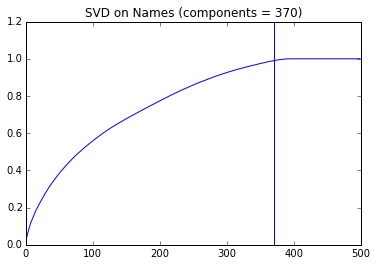

In [197]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

threshold = .99 # how much variance to keep
var_cum = np.cumsum(svd.explained_variance_ratio_)
threshold_idx = np.argmax(var_cum > threshold) # threshold index
plt.plot(var_cum)
plt.ylim(0,1.2)
plt.axvline(x = threshold_idx)
plt.title('SVD on Names (components = %s)' %threshold_idx)
plt.show()

In [199]:
# use the threshold index components instead because of elbow rule

reduced_lsa = train_lsa[:,:threshold_idx]

from sklearn.cluster import KMeans

num_clusters = range(5,100) # a range of clusters from 5 to 100

%time KM = [KMeans(n_clusters=k).fit(reduced_lsa) for k in num_clusters] #train on reduced lsa

CPU times: user 32.4 s, sys: 3 s, total: 35.4 s
Wall time: 23.5 s


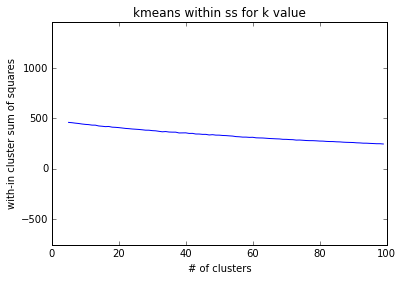

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the within cluster sum of squares
with_in_cluster = [KM[k].inertia_ for k in range(0,len(num_clusters))]
plt.plot(num_clusters, with_in_cluster)
plt.ylim(min(with_in_cluster)-1000, max(with_in_cluster)+1000)
plt.ylabel('with-in cluster sum of squares')
plt.xlabel('# of clusters')
plt.title('kmeans within ss for k value')
plt.show()

# plot the within cluster sum of squares and there doesnt seem to be much change from 5 to 100.

In [201]:
# since change is minimal i will use 5 clusters, let's save it
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(KM[0],  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [208]:
# add cluster to df_new
df_new['cluster'] = clusters